In [207]:
import torch
torch.manual_seed(100)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [208]:
import os
import pandas as pd
import numpy as np
import random

In [214]:
seed = 100

def file_name(file_dir,file_type='.csv'):#默认为文件夹下的所有文件
    lst = []
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            if(file_type == ''):
                lst.append(file)
            else:
                if os.path.splitext(file)[1] == str(file_type):#获取指定类型的文件名
                    lst.append(file)
    return lst

def normalize0(inputs):
    normalized = []
    for eq in inputs:
        maks = np.max(np.abs(eq))
        if maks != 0:
            normalized.append(eq / maks)
        else:
            normalized.append(eq)
    return np.array(normalized)


def normalize1(inputs):
    normalized = []
    for eq in inputs:
        mean = np.mean(eq)
        std = np.std(eq)
        if std != 0:
            normalized.append((eq - mean) / std)
        else:
            normalized.append(eq)
    return np.array(normalized)


def normalize(inputs):
    normalized = []
    for eq in inputs:
        with np.errstate(invalid='ignore'):
            eq_log = [np.log(x) if i < 5 else x for i, x in enumerate(eq)]
            eq_log1 = np.nan_to_num(eq_log).tolist()
            normalized.append(eq_log1)
    return np.array(normalized)


def k_fold_split(inputs, targets, K, seed=None):
    # 确保所有随机操作都使用相同的种子
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    ind = int(len(inputs) / K)
    inputsK = []
    targetsK = []

    for i in range(0, K - 1):
        inputsK.append(inputs[i * ind:(i + 1) * ind])
        targetsK.append(targets[i * ind:(i + 1) * ind])

    inputsK.append(inputs[(i + 1) * ind:])
    targetsK.append(targets[(i + 1) * ind:])

    return inputsK, targetsK


def merge_splits(inputs, targets, k, K):
    if k != 0:
        z = 0
        inputsTrain = inputs[z]
        targetsTrain = targets[z]
    else:
        z = 1
        inputsTrain = inputs[z]
        targetsTrain = targets[z]

    for i in range(z + 1, K):
        if i != k:
            inputsTrain = np.concatenate((inputsTrain, inputs[i]))
            targetsTrain = np.concatenate((targetsTrain, targets[i]))

    return inputsTrain, targetsTrain, inputs[k], targets[k]


def targets_to_list(targets):
    targetList = np.array(targets)

    return targetList


In [263]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv

class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.DoubleTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.DoubleTensor(out_features)) 
        else:
            self.register_parameter('bias', None)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            output = output + self.bias
        return output

class GCNModel(nn.Module):
    def __init__(self, input_shape):
        super(GCNModel, self).__init__()
        reg_const = 0.0001
        self.conv1 = GraphConvolution(input_shape[1],8)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = GraphConvolution(8, 8)
        self.relu2 = nn.LeakyReLU()
        self.conv3 = GraphConvolution(8, 8, bias=True)
        self.relu3 = nn.LeakyReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)
        self.dense1 = nn.Linear(16, 8)
        self.dense2 = nn.Linear(8, 1)

    def forward(self, wav_input, graph_input, graph_features):
        out = self.conv1(wav_input, graph_input)
        out = self.relu1(out)
        out = self.conv2(out, graph_input)
        out = self.relu2(out)
        out = self.conv3(out, graph_input)
        # print(wav_input.dtype,graph_input.dtype,graph_features.dtype)
        conv1_new = self.relu3(out)
        last_column = conv1_new[:, :, -1]
        conv1_new = last_column.unsqueeze(-1)
        conv1_new = self.flatten(conv1_new)
        conv1_new = self.dropout(conv1_new)
        self.dense1.weight = torch.nn.Parameter(self.dense1.weight.to(torch.float64))
        self.dense1.bias = torch.nn.Parameter(self.dense1.bias.to(torch.float64))
        self.dense2.weight = torch.nn.Parameter(self.dense2.weight.to(torch.float64))
        self.dense2.bias = torch.nn.Parameter(self.dense2.bias.to(torch.float64))
        conv1_new = conv1_new.to(self.dense1.weight.dtype)# 将 conv1_new 转换为与 dense1 权重相同的数据类型
        merged = self.dense1(conv1_new)       
        y_hat = self.dense2(merged)
        return y_hat

    
    def fit(self,train_loader, val_loader,num_epochs=5000, patience=50):
        #best_val_loss = float('inf')
        best_val_loss = torch.tensor(float('inf'), dtype=torch.double)
        patience_counter = 0
        optimizer = optim.RMSprop(self.parameters(), lr=0.00015,weight_decay=0.)
        criterion = nn.MSELoss()

        for epoch in range(num_epochs):
            self.train()
            for inputs, graph_input, graph_feature, targets in train_loader:
                optimizer.zero_grad()
                outputs = self(inputs, graph_input, graph_feature)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            self.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_inputs, val_graph_input, val_graph_feature, val_targets in val_loader:
                    val_outputs = self(val_inputs, val_graph_input, val_graph_feature)
                    val_loss += criterion(val_outputs, val_targets).item()

            val_loss /= len(val_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}')

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    return
                
                
    def test(self,test_loader):
        self.eval()
        predictions = []
        for test_inputs, test_graph_input, test_graph_feature, _ in test_loader:
            batch_predictions = self(test_inputs, test_graph_input,test_graph_feature)
            predictions.append(batch_predictions)
        predictions = torch.cat(predictions)



In [264]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Assuming your PyTorch model is defined as before


if __name__ == "__main__":
    # stock_info = sys.argv[0]
    # lag_bin = int(sys.argv[1])
    # lag_day = int(sys.argv[2])
    # bin_num = int(sys.argv[3])
    # random_state_here = int(sys.argv[4])
    # test_set_size = float(sys.argv[5])
    lag_bin = 3
    lag_day = 3
    num_nodes = (int(lag_bin)+1)*(int(lag_day)+1)
    forecast_days = 15
    bin_num=24
    random_state_here = 88
    mape_list = []
    data_dir = './data/volume/0308/'
    files =file_name('./data/')
    stocks_info = list(set(s.split('_25')[0] for s in files))
    print(stocks_info)
    for stock_info in stocks_info[0:2]:
        print(f'>>>>>>>>>>>>>>>>>>>>{stock_info}>>>>>>>>>>>>>>>>>>>>>>>')
        data_dir1 = f'{data_dir}{stock_info}_{lag_bin}_{lag_day}'
        test_set_size = bin_num*forecast_days
        K = 5
        inputs_data = np.load(f'{data_dir1}_inputs.npy', allow_pickle=True)#.astype(np.float64)
        #inputs_data = [[[float(x) for x in sublist] for sublist in list1] for list1 in inputs_data]
        inputs_data = [[[torch.tensor(x, dtype=torch.float64) for x in sublist] for sublist in list1] for list1 in inputs_data]
        array_data = np.array(inputs_data)
        inputs = np.reshape(array_data, (len(inputs_data), num_nodes,-1))
        targets = np.load(f'{data_dir1}_output.npy', allow_pickle=True).astype(np.float64)
        graph_input = np.load(f'{data_dir1}_graph_input.npy', allow_pickle=True).astype(np.float64)
        graph_input = np.array([graph_input] * inputs.shape[0])

        graph_features = np.load(f'{data_dir1}_graph_coords.npy', allow_pickle=True).astype(np.float64)
        graph_features = np.array([graph_features] * inputs.shape[0])

        trainInputs, testInputs, traingraphInput, testgraphInput, traingraphFeature, testgraphFeature, trainTargets, testTargets = train_test_split(inputs, graph_input, graph_features, targets, test_size=test_set_size, 
                                                     random_state=random_state_here)
        testInputs = normalize(testInputs)
        # testInputs = test_inputs
        inputsK, targetsK = k_fold_split(trainInputs, trainTargets, K)

        mape_list = []

# # Assuming testInputs, testGraphInput, testGraphFeature, and testTargets are PyTorch tensors
#         print(testInputs.shape)      # 确保 testInputs 的大小一致
#         print(testgraphInput.shape)  # 确保 testgraphInput 的大小一致
#         print(testgraphFeature.shape) # 确保 testgraphFeature 的大小一致
#         print(testTargets.shape)     # 确保 testTargets 的大小一致
        print(testInputs,testgraphInput,testgraphFeature)
        test_dataset = TensorDataset(torch.tensor(testInputs), torch.tensor(testgraphInput), torch.tensor(testgraphFeature), torch.tensor(testTargets))
        test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)
        K = 5  # Number of folds
        for k in range(K):
            torch.manual_seed(0)  # Set a random seed for reproducibility

            trainInputsAll, trainTargets, valInputsAll, valTargets = merge_splits(inputsK, targetsK, k, K)

            trainGraphInput = traingraphInput[0:trainInputsAll.shape[0], :]
            trainGraphFeatureInput = traingraphFeature[0:trainInputsAll.shape[0], :]

            valGraphInput = traingraphInput[0:valInputsAll.shape[0], :]
            valGraphFeatureInput = traingraphFeature[0:valInputsAll.shape[0], :]

            trainInputs = normalize(trainInputsAll[:, :])
            valInputs = normalize(valInputsAll[:, :])

            # Assuming trainInputs, trainGraphInput, trainGraphFeatureInput, trainTargets are PyTorch tensors
            train_dataset = TensorDataset(torch.tensor(trainInputs), torch.tensor(trainGraphInput),torch.tensor(trainGraphFeatureInput), torch.tensor(trainTargets))
            val_dataset = TensorDataset(torch.tensor(valInputs), torch.tensor(valGraphInput), torch.tensor(valGraphFeatureInput), torch.tensor(valTargets))

            # train_dataset = TensorDataset(torch.tensor(trainInputs, dtype=torch.float32), torch.tensor(trainGraphInput, dtype=torch.float32), torch.tensor(trainGraphFeatureInput, dtype=torch.float32), torch.tensor(trainTargets, dtype=torch.float32))
            # val_dataset = TensorDataset(torch.tensor(valInputs, dtype=torch.float32), torch.tensor(valGraphInput, dtype=torch.float32), torch.tensor(valGraphFeatureInput, dtype=torch.float32), torch.tensor(valTargets, dtype=torch.float32))

            train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

            # Instantiate the PyTorch model
            model = GCNModel(valInputs[0].shape)
            print()
            model.fit(train_loader, val_loader)
            predictions=model.test(test_loader)
            # Define optimizer and loss function
            #optimizer = optim.RMSprop(model.parameters(), lr=0.00015)
           # criterion = nn.MSELoss()

            # Train the model
            # train_model(model, train_loader, val_loader, criterion, optimizer)

            # Save the PyTorch model
            torch.save(model.state_dict(), f'models/{stock_info}_{lag_bin}_{lag_day}_gcn_model_iteration_{k}.pt')
            print(model.state_dict())
            # Evaluate on the test set
            # model.eval()
            # with torch.no_grad():
            #     predictions = []
            #     for test_inputs, test_graph_input, test_graph_feature, _ in test_loader:
            #         batch_predictions = model(test_inputs, test_graph_input, test_graph_feature)
            #         predictions.append(batch_predictions)
            #     predictions = torch.cat(predictions)

            # Perform any necessary operations with the predictions
            # ...
            print()
            print('Fold number:', k)
            print('Total number of epochs ran =', len(history))  # This is a PyTorch equivalent

            new_predictions = np.array(predictions)
            print(type(new_predictions))
            print(new_predictions.shape)
            # new_predictions = new_predictions.squeeze().tolist()
            new_predictions = [item for sublist in new_predictions for item in sublist]
            MAPE = []

            # MAPE.append(mean_absolute_percentage_error(trainTargets[:], new_predictions[:]))
            # testTargets0 = [item for sublist in trainTargets for item in sublist]
            print(testTargets)
            print(new_predictions)
            MAPE.append(mean_absolute_percentage_error(testTargets[:], new_predictions[:]))
            print(MAPE)
            # testTargets0 = [item for sublist in testTargets for item in sublist]
            testTargets0 = list(testTargets)

            res = {
                'testTargets': testTargets0,
                'new_predictions': new_predictions
            }

            res_df = pd.DataFrame(res)
            res_df.to_csv(f'./result/{stock_info}_{lag_bin}_{lag_day}_res_test_MAPE{k}.csv', index=False)

            print('MAPE = ', np.array(MAPE).mean())
            MAPE_mean = np.array(MAPE).mean()
            mape_list.append(MAPE)

        print('-')
        print('mape score = ', mape_list)


        
        


['000753_XSHE', '600622_XSHG', '002882_XSHE', '002282_XSHE', '300540_XSHE', '000998_XSHE', '603053_XSHG', '300343_XSHE', '603359_XSHG', '000951_XSHE', '000046_XSHE', '300263_XSHE', '300133_XSHE', '300174_XSHE', '002841_XSHE', '603095_XSHG', '300433_XSHE', '002679_XSHE']
>>>>>>>>>>>>>>>>>>>>000753_XSHE>>>>>>>>>>>>>>>>>>>>>>>


/tmp/ipykernel_413882/740401852.py:41: RuntimeWarning: divide by zero encountered in log
  eq_log = [np.log(x) if i < 5 else x for i, x in enumerate(eq)]


[[[ 1.31969141e+01  1.60103780e+01  1.34574613e+01 ...  1.35571284e+01
   -4.81589122e+00 -9.47265536e-01]
  [ 1.30766419e+01  1.60622092e+01  1.34914734e+01 ...  1.28474001e+01
   -4.90627528e+00  0.00000000e+00]
  [ 1.28111370e+01  1.61002106e+01  1.30408843e+01 ...  1.15636186e+01
   -4.80362112e+00  0.00000000e+00]
  ...
  [ 1.28400000e+05  4.94675040e+06  3.80165467e+05 ...  4.29603000e+05
    5.50000000e-03 -2.35700000e-01]
  [ 2.20200000e+05  5.16695040e+06  2.07600000e+05 ...  4.42600000e+05
    3.80000000e-03  6.36000000e-01]
  [ 1.97500000e+05  5.36445040e+06  1.82033333e+05 ...  3.57200000e+05
    4.70000000e-03  6.59900000e-01]]

 [[ 1.04072886e+01  1.37340836e+01  1.10092961e+01 ...  1.31515039e+01
   -5.33913936e+00 -6.65142984e-01]
  [ 1.07320394e+01  1.37825741e+01  1.10375742e+01 ...  1.21034861e+01
   -5.31852007e+00 -2.66786841e+00]
  [ 1.04341158e+01  1.38171093e+01  1.05356455e+01 ...  1.26835483e+01
   -5.29831737e+00 -1.22997461e+00]
  ...
  [ 2.00000000e+05  1.3

TypeError: iteration over a 0-d array

In [265]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(root=".", name="chameleon", transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]

URLError: <urlopen error [Errno 111] Connection refused>

In [75]:
import numpy as np
npy=np.load('/volume1/home/rzhu/gcn/data/volume/0308/000753_XSHE_3_3_inputs.npy',allow_pickle=True)
npy

array([[list([306000.0, 306000.0, 306000.0, 0.0495, 306000.0, 0.0075, 0.5911]),
        list([74052.0, 380052.0, 190026.0, 0.012, 74052.0, 0.005, 0.2295]),
        list([78600.0, 458652.0, 152884.0, 0.0127, 78600.0, 0.0054, 0.7465]),
        ...,
        list([277000.0, 631300.0, 315650.0, 0.0673, 74052.0, 0.0056, -0.0506]),
        list([241800.0, 873100.0, 291033.3333, 0.0319, 78600.0, 0.0064, -0.374]),
        list([383500.0, 1256600.0, 300766.6667, 0.0498, 43300.0, 0.0042, 0.0942])],
       [list([74052.0, 380052.0, 190026.0, 0.012, 74052.0, 0.005, 0.2295]),
        list([78600.0, 458652.0, 152884.0, 0.0127, 78600.0, 0.0054, 0.7465]),
        list([43300.0, 501952.0, 65317.3333, 0.007, 43300.0, 0.005, 0.7203]),
        ...,
        list([241800.0, 873100.0, 291033.3333, 0.0319, 78600.0, 0.0064, -0.374]),
        list([383500.0, 1256600.0, 300766.6667, 0.0498, 43300.0, 0.0042, 0.0942]),
        list([184038.0, 1440638.0, 269779.3333, 0.0395, 58000.0, 0.0029, -0.4787])],
       [list

In [12]:
npy[0]

array([list([306000.0, 306000.0, 306000.0, 0.0495, 306000.0, 0.0075, 0.5911]),
       list([74052.0, 380052.0, 190026.0, 0.012, 74052.0, 0.005, 0.2295]),
       list([78600.0, 458652.0, 152884.0, 0.0127, 78600.0, 0.0054, 0.7465]),
       list([43300.0, 501952.0, 65317.3333, 0.007, 43300.0, 0.005, 0.7203]),
       list([201200.0, 201200.0, 201200.0, 0.0562, 306000.0, 0.0037, 0.2074]),
       list([309192.0, 510392.0, 255196.0, 0.0543, 74052.0, 0.005, 0.6722]),
       list([56902.0, 567294.0, 189098.0, 0.0152, 78600.0, 0.0039, -0.4877]),
       list([150900.0, 718194.0, 172331.3333, 0.0271, 43300.0, 0.0026, -0.6175]),
       list([328700.0, 328700.0, 328700.0, 0.0606, 306000.0, 0.0059, -0.0346]),
       list([192400.0, 521100.0, 260550.0, 0.0498, 74052.0, 0.0036, 0.3343]),
       list([101100.0, 622200.0, 207400.0, 0.0173, 78600.0, 0.005, -0.0357]),
       list([59600.0, 681800.0, 117700.0, 0.0222, 43300.0, 0.0029, 0.2037]),
       list([354300.0, 354300.0, 354300.0, 0.0717, 306000.0, 0.

In [10]:
def draw_adj(adj_matrix,lag_bin, lag_day,station_coords):
    # 可视化有向图
    G = nx.DiGraph(adj_matrix.T)
    res = {}
    for i in range(len(station_coords)):
        res[i] = [station_coords[i][0], abs(station_coords[i][1])]

    res = dict(sorted(res.items(), key=lambda x: x[1][1], reverse=True))

    pos = {}
    for i, key in enumerate(res.keys()):
        pos[i] = res[key]

    plt.figure(figsize=(4, 4))
    nx.draw_networkx(G,pos=pos,  with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
    plt.title("Directed Graph")
    plt.axis('off')
    plt.show()


In [70]:
adj_matrix=np.load('/volume1/home/rzhu/gcn/data/volume/0308/300343_XSHE_3_3_graph_input.npy')
station_coords = np.load('/volume1/home/rzhu/gcn/data/volume/0308/300343_XSHE_3_3_graph_coords.npy')

In [71]:
import numpy as np

In [72]:
adj_matrix

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.70710678, 0.5       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.5       , 0.5       , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.5       , 0.5       , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.70710678, 0.        , 0.        , 0.        , 0.5       ,
        0.        , 0.        , 

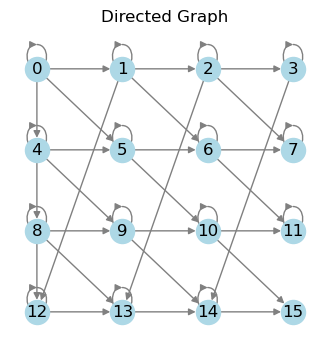

In [73]:
draw_adj(adj_matrix,3, 3,station_coords)

In [62]:
import networkx as nx

In [63]:
import matplotlib.pyplot as plt

In [ ]:

    matrix_size = (lag_bin +1)*(lag_day + 1) 
    adj_matrix = np.zeros((matrix_size, matrix_size))
    node0=[]
    node1=[]
    for i in range(lag_day+1):
        node0.append((lag_bin+1)*i)
#         if(i>0):
#             node1.append((lag_bin+1)*(i+1)-1)

    for i in range(1, matrix_size):
        if (i not in node0):
            adj_matrix[i, i - 1] = 1
            adj_matrix[i, i-(lag_bin+1) - 1] = 1
        else:
            adj_matrix[i, i - 1 - lag_bin] = 1


In [48]:
matrix_size = (3 +1)*(3 + 1)

In [49]:
adj_matrix = np.zeros((matrix_size, matrix_size))
adj_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [50]:
node0=[]
node1=[]

In [51]:
 for i in range(3+1):
        node0.append((3+1)*i)
print(node0)

[0, 4, 8, 12]


In [52]:
for i in range(1, matrix_size):
    if (i not in node0):
        adj_matrix[i, i - 1] = 1
        if i>4: 
            adj_matrix[i, i-(3+1) - 1] = 1
        else:
            adj_matrix[i-(3+1) - 1,i] = 1
    else:
        adj_matrix[i, i - 1 - 3] = 1

In [53]:
print(adj_matrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]]


NameError: name 'torch' is not defined